# Assignment 2: Sequence to Sequence Natural Language to SQL

Lucas Ortiz Duhart
lo21410

## Imports

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from sklearn.model_selection import train_test_split

## Data Preprocessing

In [2]:
df = pd.read_json('https://raw.githubusercontent.com/Lucothron/CE888-DataScience/main/CE888-master/CE888-master/Assignment%202/train_spider.json')

df.shape

(7000, 7)

In [3]:
df.head()

,db_id,query,query_toks,query_toks_no_value,question,question_toks,sql
0,department_management,SELECT count(*) FROM head WHERE age > 56,"[SELECT, count, (, *, ), FROM, head, WHERE, ag...","[select, count, (, *, ), from, head, where, ag...",How many heads of the departments are older th...,"[How, many, heads, of, the, departments, are, ...","{'from': {'table_units': [['table_unit', 1]], ..."
1,department_management,"SELECT name , born_state , age FROM head ORD...","[SELECT, name, ,, born_state, ,, age, FROM, he...","[select, name, ,, born_state, ,, age, from, he...","List the name, born state and age of the heads...","[List, the, name, ,, born, state, and, age, of...","{'from': {'table_units': [['table_unit', 1]], ..."
2,department_management,"SELECT creation , name , budget_in_billions ...","[SELECT, creation, ,, name, ,, budget_in_billi...","[select, creation, ,, name, ,, budget_in_billi...","List the creation year, name and budget of eac...","[List, the, creation, year, ,, name, and, budg...","{'from': {'table_units': [['table_unit', 0]], ..."
3,department_management,"SELECT max(budget_in_billions) , min(budget_i...","[SELECT, max, (, budget_in_billions, ), ,, min...","[select, max, (, budget_in_billions, ), ,, min...",What are the maximum and minimum budget of the...,"[What, are, the, maximum, and, minimum, budget...","{'from': {'table_units': [['table_unit', 0]], ..."
4,department_management,SELECT avg(num_employees) FROM department WHER...,"[SELECT, avg, (, num_employees, ), FROM, depar...","[select, avg, (, num_employees, ), from, depar...",What is the average number of employees of the...,"[What, is, the, average, number, of, employees...","{'from': {'table_units': [['table_unit', 0]], ..."


In [4]:
# Select only queries that include 'avg', 'min', 'max', or 'count' as they are more mathematically inclined

count = 0
data = []
for row in df.itertuples(index = False):
  if 'avg' in row[3] or 'min' in row[3] or 'max' in row[3] or 'count' in row[3]:
    count += 1
    data.append(row)
    #print(row[3])

df_new = pd.DataFrame(data)
df_clean = df_new.drop(['db_id', 'query_toks', 'query_toks_no_value', 'question_toks', 'sql'], axis = 1)

num_pairs = df_clean.shape[0]

df_clean.head()

,query,question
0,SELECT count(*) FROM head WHERE age > 56,How many heads of the departments are older th...
1,"SELECT max(budget_in_billions) , min(budget_i...",What are the maximum and minimum budget of the...
2,SELECT avg(num_employees) FROM department WHER...,What is the average number of employees of the...
3,SELECT born_state FROM head GROUP BY born_stat...,What are the names of the states where at leas...
4,SELECT creation FROM department GROUP BY creat...,In which year were most departments established?


In [5]:
new_data = []
for index, value in df_clean['query'].items():
  new_val = '$ ' + value + ' @'
  new_data.append(new_val)

start_end_data = pd.Series(new_data)
df_start_end = df_clean.assign(query_chars = start_end_data)

In [6]:
df_chars = df_start_end.drop(['query'], axis=1)

df_chars.head()

,question,query_chars
0,How many heads of the departments are older th...,$ SELECT count(*) FROM head WHERE age > 56 @
1,What are the maximum and minimum budget of the...,"$ SELECT max(budget_in_billions) , min(budget..."
2,What is the average number of employees of the...,$ SELECT avg(num_employees) FROM department WH...
3,What are the names of the states where at leas...,$ SELECT born_state FROM head GROUP BY born_st...
4,In which year were most departments established?,$ SELECT creation FROM department GROUP BY cre...


In [7]:
def numChars(data):
  chars = []
  charCount = 0

  for line in data:
    for char in line:
      if char not in chars:
        chars.append(char)
        charCount += 1

  return charCount, chars

def maxLength(data):
  max = 0

  for line in data:
    temp = len(line)
    if temp > max:
      max = temp
  
  return max

In [8]:
x = df_chars['question'].tolist()
y = df_chars['query_chars'].tolist()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [9]:
print(X_train)
print(y_train)

['List the name of the aircraft that has been named winning aircraft the most number of times.', 'Show the average age for male and female students.', 'How many music festivals have had each kind of result, ordered descending by count?', 'Which order has the most recent shipment? Give me the order id.', "Which countries has the most number of airlines whose active status is 'Y'?", 'What are the minimum and maximum vote percents of elections?', 'For each project id, how many tasks are there?', 'Find the number of rooms with price higher than 120 for different decor.', 'Find the top 3 wineries with the greatest number of wines made of white color grapes.', 'How many movie directors are there?', 'Compute the average active time span of contact channels.', 'Which room has the largest number of reservations?', 'How many transactions do we have?', 'Which policy type has the most records in the database?', 'What is the average bike availablility for stations not in Palo Alto?', 'Find the name

In [10]:
print(X_test)
print(y_test)

['Find the number of students in one classroom.', 'Show all allergy types and the number of allergies in each type.', 'How many professors are in the accounting dept?', 'List the types of competition that have at most five competitions of that type.', "How many players born in USA are right-handed batters? That is, have the batter value 'R'.", 'How many trips started from Mountain View city and ended at Palo Alto city?', 'Give the average price and case of wines made from Zinfandel grapes in the year 2009.', 'Show the id of each employee and the number of document destruction authorised by that employee.', 'What is maximum and minimum RAM size of phone produced by company named "Nokia Corporation"?', 'What is the average number of gold medals for a club?', 'Return the most common full name among all actors.', 'How many parties are there?', 'How many invoices were billed from Chicago, IL?', 'How many students got accepted after the tryout?', 'Find the name, address, number of students i

In [11]:
num_eng_char, input_chars = numChars(X_train)
num_sql_char, target_chars = numChars(y_train)

max_eng_sent = maxLength(X_train)
max_sql_sent = maxLength(y_train)

print(len(X_train), max_eng_sent, num_eng_char)
print(len(y_train), max_sql_sent, num_sql_char)

2141 224 73
2141 404 84


In [12]:
input_char = sorted(list(input_chars))
target_char = sorted(list(target_chars))

In [13]:
input_token_index = dict([(char, i) for i, char in enumerate(input_char)])
target_token_index = dict([(char, i) for i, char in enumerate(target_char)])

print(input_token_index)
print(target_token_index)

{' ': 0, '"': 1, '$': 2, "'": 3, '(': 4, ')': 5, ',': 6, '-': 7, '.': 8, '0': 9, '1': 10, '2': 11, '3': 12, '4': 13, '5': 14, '6': 15, '7': 16, '8': 17, '9': 18, ':': 19, '?': 20, 'A': 21, 'B': 22, 'C': 23, 'D': 24, 'E': 25, 'F': 26, 'G': 27, 'H': 28, 'I': 29, 'J': 30, 'K': 31, 'L': 32, 'M': 33, 'N': 34, 'O': 35, 'P': 36, 'R': 37, 'S': 38, 'T': 39, 'U': 40, 'V': 41, 'W': 42, 'X': 43, 'Y': 44, 'Z': 45, '_': 46, 'a': 47, 'b': 48, 'c': 49, 'd': 50, 'e': 51, 'f': 52, 'g': 53, 'h': 54, 'i': 55, 'j': 56, 'k': 57, 'l': 58, 'm': 59, 'n': 60, 'o': 61, 'p': 62, 'q': 63, 'r': 64, 's': 65, 't': 66, 'u': 67, 'v': 68, 'w': 69, 'x': 70, 'y': 71, 'z': 72}
{'\t': 0, ' ': 1, '!': 2, '"': 3, '$': 4, '%': 5, "'": 6, '(': 7, ')': 8, '*': 9, '+': 10, ',': 11, '-': 12, '.': 13, '/': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, ';': 26, '<': 27, '=': 28, '>': 29, '@': 30, 'A': 31, 'B': 32, 'C': 33, 'D': 34, 'E': 35, 'F': 36, 'G': 37, 'H': 38, 'I': 39, 

In [14]:
encoder_inp_data = np.zeros(
    (len(X_train), max_eng_sent, num_eng_char), dtype='float32')
decoder_inp_data = np.zeros(
    (len(y_train), max_sql_sent, num_sql_char), dtype='float32')
decoder_target_data = np.zeros(
    (len(y_train), max_sql_sent, num_sql_char), dtype='float32')

encoder_inp_data_test = np.zeros(
    (len(X_test), max_eng_sent, num_eng_char), dtype='float32')
decoder_inp_data_test = np.zeros(
    (len(y_test), max_sql_sent, num_sql_char), dtype='float32')
decoder_target_data_test = np.zeros(
    (len(y_test), max_sql_sent, num_sql_char), dtype='float32')

In [15]:
for i, (input_text, target_text) in enumerate(zip(X_train, y_train)):
  for t, char in enumerate(input_text):
    encoder_inp_data[i, t, input_token_index[char]] = 1.0
  encoder_inp_data[i, t + 1 :, input_token_index[" "]] = 1.0
  for t, char in enumerate(target_text):
    decoder_inp_data[i, t, target_token_index[char]] = 1.0
    if t > 0:
      decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
  decoder_inp_data[i, t + 1 :, target_token_index[" "]] = 1.0
  decoder_target_data[i, t:, target_token_index[" "]] = 1.0

In [16]:
for i, (input_text, target_text) in enumerate(zip(X_test, y_test)):
  for t, char in enumerate(input_text):
    encoder_inp_data_test[i, t, input_token_index[char]] = 1.0
  encoder_inp_data_test[i, t + 1 :, input_token_index[" "]] = 1.0
  # for t, char in enumerate(target_text):
  #   decoder_inp_data_test[i, t, target_token_index[char]] = 1.0
  #   if t > 0:
  #     decoder_target_data_test[i, t - 1, target_token_index[char]] = 1.0
  # decoder_inp_data_test[i, t + 1 :, target_token_index[" "]] = 1.0
  # decoder_target_data_test[i, t:, target_token_index[" "]] = 1.0

In [17]:
print(encoder_inp_data[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [18]:
encoder_inputs = keras.Input(shape=(None, num_eng_char))
encoder = keras.layers.LSTM(84, return_state=True)
encoder_out, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = keras.Input(shape=(None, num_sql_char))

decoder_lstm = keras.layers.LSTM(84, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_sql_char, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [19]:
model.compile(
    optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 73)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 84)]   0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 84),         53088       ['input_1[0][0]']                
                                 (None, 84),                                                      
                                 (None, 84)]                                                      
                                                                                              

In [20]:
history = model.fit(
    [encoder_inp_data, decoder_inp_data],
    decoder_target_data,
    batch_size=15,
    epochs=10,
    validation_split=0.2
)


Epoch 1/10
115/115 [==============================] - 46s 357ms/step - loss: 1.1932 - accuracy: 0.7746 - val_loss: 0.9259 - val_accuracy: 0.7827
Epoch 2/10
115/115 [==============================] - 39s 338ms/step - loss: 0.9020 - accuracy: 0.7892 - val_loss: 0.8256 - val_accuracy: 0.7918
Epoch 3/10
115/115 [==============================] - 37s 319ms/step - loss: 0.7571 - accuracy: 0.8102 - val_loss: 0.7036 - val_accuracy: 0.8240
Epoch 4/10
115/115 [==============================] - 37s 318ms/step - loss: 0.6352 - accuracy: 0.8424 - val_loss: 0.6019 - val_accuracy: 0.8533
Epoch 5/10
115/115 [==============================] - 36s 316ms/step - loss: 0.5399 - accuracy: 0.8668 - val_loss: 0.5006 - val_accuracy: 0.8776
Epoch 6/10
115/115 [==============================] - 36s 317ms/step - loss: 0.4664 - accuracy: 0.8842 - val_loss: 0.5025 - val_accuracy: 0.8699
Epoch 7/10
115/115 [==============================] - 36s 317ms/step - loss: 0.4158 - accuracy: 0.8939 - val_loss: 0.4069 - val_ac

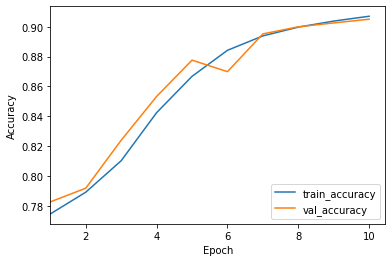

In [21]:
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['accuracy'], label='train_accuracy')
plt.plot(epochs, history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim([1, None])
plt.legend(loc='lower right')
plt.savefig('Accuracy', dpi=1200)

In [25]:
encoder_inputs = model.input[0]
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]
decoder_state_input_h = keras.Input(shape=(84,))
decoder_state_input_c = keras.Input(shape=(84,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)


reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, num_sql_char))
    target_seq[0, 0, target_token_index["$"]] = 1.0

    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if sampled_char == "@" or len(decoded_sentence) > max_sql_sent:
            stop_condition = True

        target_seq = np.zeros((1, 1, num_sql_char))
        target_seq[0, 0, sampled_token_index] = 1.0

        states_value = [h, c]
    return decoded_sentence

In [26]:
for seq_index in range(10):
  input_seq = encoder_inp_data_test[seq_index : seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)
  print('-')
  print('Input sentence: ', X_test[seq_index])
  print('Decoded sentence: ', decoded_sentence)

-
Input sentence:  Find the number of students in one classroom.
Decoded sentence:   SELECT T1.name FROM stount_id GROUP BY count_id ORDER BY count(*) DESC LIMIT 1 @
-
Input sentence:  Show all allergy types and the number of allergies in each type.
Decoded sentence:   SELECT T1.name FROM stount_id GROUP BY count_id ORDER BY count(*) DESC LIMIT 1 @
-
Input sentence:  How many professors are in the accounting dept?
Decoded sentence:   SELECT T1.name FROM stount_id GROUP BY count_id ORDER BY count(*) DESC LIMIT 1 @
-
Input sentence:  List the types of competition that have at most five competitions of that type.
Decoded sentence:   SELECT T1.name FROM stount_id GROUP BY count_id ORDER BY count(*) DESC LIMIT 1 @
-
Input sentence:  How many players born in USA are right-handed batters? That is, have the batter value 'R'.
Decoded sentence:   SELECT T1.name FROM stount_id GROUP BY count_id ORDER BY count(*) DESC LIMIT 1 @
-
Input sentence:  How many trips started from Mountain View city and 